## As we've been digging in to try and understand the correlation coefficients between surface fluxes and mean wind speeds/variances, it's come up that it might be better to try looking at individual sites and timeseries. 
So this will involve FLUXNET sites in particular to try and get a feel for which synoptic conditions are really hard for the model to get right, and/or which ones tend to lead to negative vs. positive correlations between wind speeds and surface fluxes. <br><br>
<b>Date:</b> 3 Dec 2020

In [1]:
# Load libraries

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib.animation as animation
import matplotlib as matplotlib
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util

# Analysis
import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
#import regionmask
import pickle
import scipy.stats as stats
import glob


## 1. Read in FLUXNET data (and filter out a few stations based on length of record)

In [2]:
# --------------------------------------
# Define data directory: 
# --------------------------------------
fluxnetDir   = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/FLUXNET2015/'

# --------------------------------------
# Get general site info
# --------------------------------------
siteInfoFile = fluxnetDir+'SiteList.csv'
# Now read that CSV file into a pandas dataframe 
siteInfoDF = pd.read_csv(siteInfoFile)

# Print out information available:
print('Available site characteristics (metadata) include: \n\n', siteInfoDF.columns.values, '\n')

# --------------------------------------
# And read in metadata for good measure
# --------------------------------------
metadataFile = fluxnetDir+'FLX_AA-Flx_BIF_ALL_20200501/FLX_AA-Flx_BIF_DD_20200501.xlsx'

# Read in that file 
metadataDF = pd.read_excel(metadataFile)


Available site characteristics (metadata) include: 

 ['SITE_ID' 'SITE_NAME' 'FLUXNET2015' 'FLUXNET-CH4' 'LOCATION_LAT'
 'LOCATION_LONG' 'LOCATION_ELEV' 'IGBP' 'MAT' 'MAP'] 



In [3]:
# --------------------------------------
# Get a list of all fluxnet data files
# --------------------------------------
dataFiles = glob.glob(fluxnetDir + 'FLX_*/*SUBSET_DD*')


In [4]:
# ------------------------------------------
# Define a function to read in FLUXNET data 
# ------------------------------------------

# --------------------------------------------------------
# Function to read requested variables from FLUXNET file. 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# 
# Inputs:  fileName --> Full path to FLUXNET data file 
#          varNames --> An array of variable names to be 
#                       retrieved from said data file. 
#                       NOTE: If you wish to retrieve *all* 
#                       variables, pass the string 'ALL'. 
#          Note: varInfo found here
#                https://fluxnet.org/data/fluxnet2015-dataset/subset-data-product/
#  
# Outputs: fluxnetID --> ID string used to identify station
#          fluxnetDS --> An x-array dataset containing the 
#                        requested variables.
#                        Missing values will be set to NaN. 
# 
# --------------------------------------------------------

def readFLUXNET_var(fileName, varNames): 
    # Get ID of station 
    startID   = fileName.find('FLX_')
    fluxnetID = fileName[startID+4:startID+10]
    
    # print('Reading in site - ', fluxnetID)
    
    # Read in CSV file containing data 
    dataDF = pd.read_csv(fileName)
    
    # Return ALL variables from dataDF if requested
    if varNames=='ALL':
        fluxnetDF = dataDF
        
        # Set any value that's missing to NaN (not -999)
        fluxnetDF = fluxnetDF.replace(-9999, np.nan)

        
        # If time has been requested, reformat to pandas make index
        fluxnetDF['TIMESTAMP'] = pd.to_datetime(fluxnetDF['TIMESTAMP'].values, format='%Y%m%d')
        fluxnetDF = fluxnetDF.set_index(['TIMESTAMP'])
        
        # Convert dataframe to Xarray Dataset (required to use coupling metrics toolbox)
        fluxnetDS = fluxnetDF.to_xarray()
            
    # Reduce returned DF to contain only variables of interest  
    else:
        
        # Check that requested variables are available in specific file
        errCount = 0                       # Initialize flag for error 
        colNames = dataDF.columns.values   # Available variables in file 
        
        for iVar in range(len(varNames)):  # Check each variable individually
            if (varNames[iVar] in colNames)==False:
                # Turn on print statement for more verbose output
                # print('** ERROR: %13s   not contained in file for %8s  **' %(varNames[iVar], fluxnetID))
                
                # If any variable is not conatined in file, return a NaN 
                fluxnetDS = -999
                errCount  = errCount+1
                
        # If all the variables *are* available, isolate those in DF and return that
        if errCount == 0: 
            fluxnetDF = dataDF[varNames]
            
            # Set any value that's missing to NaN (not -999)
            fluxnetDF = fluxnetDF.replace(-9999, np.nan)
            
            # If time has been requested, reformat to pandas make index
            if ('TIMESTAMP' in varNames)==True:
                fluxnetDF['TIMESTAMP'] = pd.to_datetime(fluxnetDF['TIMESTAMP'].values, format='%Y%m%d')
                fluxnetDF = fluxnetDF.set_index(['TIMESTAMP'])
        
            # Convert dataframe to Xarray Dataset (required to use coupling metrics toolbox)
            fluxnetDS = fluxnetDF.to_xarray()
    
    return(fluxnetID, fluxnetDS)


### 1.1 First find out total period spanned by FLUXNET data 
This will help define empty arrays that can be filled properly for each station individually, leaving NaNs on days that don't have data per station. 

In [5]:
# Define emtpy arrays to save stuff into 
startTime_fluxnet = np.full([len(dataFiles)], np.nan)
endTime_fluxnet   = np.full([len(dataFiles)], np.nan)
nMonths_fluxnet   = np.full([len(dataFiles)], np.nan)
# allStationID      = np.empty([len(dataFiles)]).astype(str)

# Variables I want returned:
varNames = ['TIMESTAMP','H_F_MDS','LE_F_MDS','WS_F','P_F','PA_F','TA_F']

# Loop over each station (data file)
for iStation in range(len(dataFiles)): 
    
    # Read in data 
    # ----------------------------------------------------------
    fluxnetID,fluxnetDS = readFLUXNET_var(dataFiles[iStation], varNames)
#     allStationID[iStation] = fluxnetID
    
    # Save lat and lon for this station 
    # ----------------------------------------------------------
    indStation  = np.where(fluxnetID==siteInfoDF['SITE_ID'])
    lat_fluxnet = siteInfoDF['LOCATION_LAT'].values[indStation]
    lon_fluxnet = siteInfoDF['LOCATION_LONG'].values[indStation]
    
    # Check that there was data saved for this particular site: 
    # ----------------------------------------------------------
    if (type(fluxnetDS)==int):
        print('No data for station: %8s' % fluxnetID)
    
    elif ( (np.all(np.isnan(fluxnetDS['H_F_MDS']))==True) | (np.all(np.isnan(fluxnetDS['WS_F']))==True) | (np.all(np.isnan(fluxnetDS['LE_F_MDS']))==True) ):
        print('No data for station: %8s' % fluxnetID)
        
    # If data is present: 
    # ----------------------------------------------------------
    else:        
        # Only consider where data is actually present for selected vars
        iReal      = np.where((np.isfinite(fluxnetDS['LE_F_MDS'])==True) & 
                              (np.isfinite(fluxnetDS['H_F_MDS'])==True) & 
                              (np.isfinite(fluxnetDS['WS_F'])==True) & 
                              (np.isfinite(fluxnetDS['P_F'])==True) &
                              (np.isfinite(fluxnetDS['PA_F'])==True) &   
                              (np.isfinite(fluxnetDS['TA_F'])==True))[0]
        fluxnetDS  = fluxnetDS.isel(TIMESTAMP=iReal)
        
        # Check how long data is available for and isolate JJA 
        # -----------------------------------------------------------
        startTime_fluxnet[iStation]  = fluxnetDS['TIMESTAMP'].values[0]
        endTime_fluxnet[iStation]    = fluxnetDS['TIMESTAMP'].values[-1]
        
        dateRange = pd.date_range(start=startTime_fluxnet[iStation],end=endTime_fluxnet[iStation],freq='M')
        nMonths_fluxnet[iStation] = len(dateRange)
        

In [6]:
# Check how many/which stations have enough years of data to be used, then
#    print some useful information on all that and 

iMinStart = np.where(startTime_fluxnet==np.nanmin(startTime_fluxnet))[0]
iMaxEnd   = np.where(endTime_fluxnet==np.nanmax(endTime_fluxnet))[0]

limYears = 5 
iStation_limYears = np.where(nMonths_fluxnet>=limYears*12)[0]

print('Number of stations with at least 5 years of data: ', len(iStation_limYears))
print()

print('Looking at every station available...')
print('Earliest start of data:    ', pd.DatetimeIndex(startTime_fluxnet[iMinStart])[0] )
print('Latest end of data:        ', pd.DatetimeIndex(endTime_fluxnet[iMaxEnd])[0] )

print()
del iMinStart
del iMaxEnd

startTime_fluxnet_sel = startTime_fluxnet[iStation_limYears]
endTime_fluxnet_sel   = endTime_fluxnet[iStation_limYears]

iMinStart = np.where(startTime_fluxnet_sel==np.nanmin(startTime_fluxnet_sel))[0]
iMaxEnd   = np.where(endTime_fluxnet_sel==np.nanmax(endTime_fluxnet_sel))[0]
print('Of stations with at least 5 years of data...')
print('Earliest start of data:    ', pd.DatetimeIndex(startTime_fluxnet_sel[iMinStart])[0] )
print('Latest end of data:        ', pd.DatetimeIndex(endTime_fluxnet_sel[iMaxEnd])[0] )


Number of stations with at least 5 years of data:  116

Looking at every station available...
Earliest start of data:     1991-01-01 00:00:00
Latest end of data:         2014-12-31 00:00:00

Of stations with at least 5 years of data...
Earliest start of data:     1991-01-01 00:00:00
Latest end of data:         2014-12-31 00:00:00


In [7]:
# So let's filter stations to use just the ones that have at least 5 years of data 
#    (or whatever the limYears threshold is set to above...)
dataFiles_filter = np.squeeze(dataFiles)[iStation_limYears]

# Let's also figure out just how many days we'll need to create empty arrays for 
dayRange = pd.date_range(start=pd.DatetimeIndex(startTime_fluxnet_sel[iMinStart])[0],
                         end=pd.DatetimeIndex(endTime_fluxnet_sel[iMaxEnd])[0],
                         freq='D')
nDays = len(dayRange)

print('Max number of days: ', nDays)

Max number of days:  8766


### 1.2 Now read in and save data for each individual tower site

In [8]:
# Define emtpy arrays to save stuff into 
lat_fluxnet     = np.full([len(dataFiles_filter)], np.nan)
lon_fluxnet     = np.full([len(dataFiles_filter)], np.nan)
stationID       = np.empty([len(dataFiles_filter)]).astype(str)
fluxnet_SH      = np.full([len(dataFiles_filter), nDays], np.nan)    # H_F_MDS  [W/m2]
fluxnet_LH      = np.full([len(dataFiles_filter), nDays], np.nan)    # LE_F_MDS [W/m2] 
fluxnet_spd     = np.full([len(dataFiles_filter), nDays], np.nan)    # WS_F     [m/s]
fluxnet_precip  = np.full([len(dataFiles_filter), nDays], np.nan)    # P_F      [mm/day - summed from half/hourly for daily data]
fluxnet_pressr  = np.full([len(dataFiles_filter), nDays], np.nan)    # PA_F     [kPa] -- seriously? kPa? 
fluxnet_temp    = np.full([len(dataFiles_filter), nDays], np.nan)    # TA_F     [deg C]

# Variables I want returned:
varNames = ['TIMESTAMP','H_F_MDS','LE_F_MDS','WS_F','P_F','PA_F','TA_F']

# Loop over each station (data file)
for iStation in range(len(dataFiles_filter)):
    
    # Read in data 
    # ----------------------------------------------------------
    fluxnetID,fluxnetDS = readFLUXNET_var(dataFiles_filter[iStation], varNames)
    
    # Save lat and lon for this station 
    # ----------------------------------------------------------
    indStation            = np.where(fluxnetID==siteInfoDF['SITE_ID'])
    lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
    lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
    stationID[iStation]   = fluxnetID
    
    # Check that there was data saved for this particular site: 
    # ----------------------------------------------------------
    if (type(fluxnetDS)==int):
        print('No data for station: %8s' % fluxnetID)
    
    elif ( (np.all(np.isnan(fluxnetDS['H_F_MDS']))==True) | (np.all(np.isnan(fluxnetDS['WS_F']))==True) | (np.all(np.isnan(fluxnetDS['LE_F_MDS']))==True) ):
        print('No data for station: %8s' % fluxnetID)
        
    # If data is present: 
    # ----------------------------------------------------------
    else:        
        # Only consider where data is actually present for selected vars
        iReal      = np.where((np.isfinite(fluxnetDS['LE_F_MDS'])==True) & 
                              (np.isfinite(fluxnetDS['H_F_MDS'])==True) & 
                              (np.isfinite(fluxnetDS['WS_F'])==True) & 
                              (np.isfinite(fluxnetDS['P_F'])==True) &
                              (np.isfinite(fluxnetDS['PA_F'])==True) &   
                              (np.isfinite(fluxnetDS['TA_F'])==True))[0]
        fluxnetDS  = fluxnetDS.isel(TIMESTAMP=iReal)
 
        
        # Check where to save data in time arrays 
        # -----------------------------------------------------------
        startTime_fluxnet = pd.DatetimeIndex(fluxnetDS['TIMESTAMP'].values)[0]
        endTime_fluxnet   = pd.DatetimeIndex(fluxnetDS['TIMESTAMP'].values)[-1]
        
        iTime_start = int(np.where(startTime_fluxnet==dayRange)[0])
        iTime_end   = int(np.where(endTime_fluxnet==dayRange)[0])
       
        # Save timeseries of each variable out to arrays 
        # -----------------------------------------------------------
        fluxnet_SH[iStation,iTime_start:(iTime_end+1)]     = fluxnetDS['H_F_MDS'].values
        fluxnet_LH[iStation,iTime_start:(iTime_end+1)]     = fluxnetDS['LE_F_MDS'].values
        fluxnet_spd[iStation,iTime_start:(iTime_end+1)]    = fluxnetDS['WS_F'].values
        fluxnet_precip[iStation,iTime_start:(iTime_end+1)] = fluxnetDS['P_F'].values
        fluxnet_pressr[iStation,iTime_start:(iTime_end+1)] = fluxnetDS['PA_F'].values
        fluxnet_temp[iStation,iTime_start:(iTime_end+1)]   = fluxnetDS['TA_F'].values


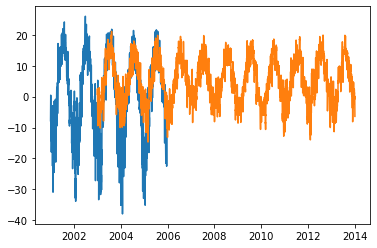

In [9]:
# Plot a few stations of temperature to make sure it exists and seems okay... 
plt.plot(dayRange, fluxnet_temp[10,:])
plt.plot(dayRange, fluxnet_temp[78,:])


## 2. Read in model data 

Note: Created a netCDF file containing model data at gridcells that line up with the FLUXNET stations, so just read that in.

In [35]:
dataPath = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/processed_dailyCESMatFLUXNETstations.nc'
modelDS  = xr.open_dataset(dataPath, decode_times=True)


In [10]:
# # Set up directories 
# dataDir     = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/daily/'
# nameStart   = 'f.e20.FHIST.f09_f09.cesm2_1.001.cam.h1.'
# nameEnd_UV  = '_sfcLevs-dailyUV.nc'
# nameEnd_FLX = '_dailySfcFluxes.nc'
# nameEnd_TS  = '_TSprecip.nc'

# decadeList  = ['1990-99','2000-14']


In [12]:
# # Read in data by decade 
# for iDec in range(len(decadeList)): 
    
#     # Open datasets for each decade 
# #     fileName       = dataDir+nameStart+decadeList[iDec]+nameEnd
# #     dataDF         = xr.open_dataset(fileName, decode_times=True)
# #     dataDF['time'] = dataDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime

#     UVfile         = dataDir+nameStart+decadeList[iDec]+nameEnd_UV 
#     windDF         = xr.open_dataset(UVfile, decode_times=True)
#     windDF['time'] = windDF.indexes['time'].to_datetimeindex()
    
#     FLXfile       = dataDir+nameStart+decadeList[iDec]+nameEnd_FLX
#     flxDF         = xr.open_dataset(FLXfile, decode_times=True)
#     flxDF['time'] = flxDF.indexes['time'].to_datetimeindex()
    
#     TSfile        = dataDir+nameStart+decadeList[iDec]+nameEnd_TS
#     tsDF          = xr.open_dataset(TSfile, decode_times=True)
#     tsDF['time']  = tsDF.indexes['time'].to_datetimeindex()

#     # Create *giant* datasets that span the full period of the simulations
#     if iDec==0:
# #         fullDF   = dataDF
#         fullUV   = windDF
#         fullFLX  = flxDF
#         fullTS   = tsDF
#     else:
# #         fullDF   = xr.concat([fullDF, dataDF], dim="time")
#         fullUV   = xr.concat([fullUV, windDF], dim="time")
#         fullFLX  = xr.concat([fullFLX, flxDF], dim="time")
#         fullTS   = xr.concat([fullTS,   tsDF], dim="time")
        
#     windDF.close()
#     flxDF.close()
#     tsDF.close()
        
#     print('Done with decade ', decadeList[iDec], ' ... ')
    

<ipython-input-12-e10f59f11f62>:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  windDF['time'] = windDF.indexes['time'].to_datetimeindex()
<ipython-input-12-e10f59f11f62>:15: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  flxDF['time'] = flxDF.indexes['time'].to_datetimeindex()
<ipython-input-12-e10f59f11f62>:19: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between da

Done with decade  1990-99  ... 
Done with decade  2000-14  ... 


In [62]:
# print('Units on precip: ', tsDF.PRECT.units)
# print('Units on TS:     ', tsDF.TS.units)
# print('Units on fluxes: ', flxDF.SHFLX.units)
# print('Units on wind:   ', windDF.U.units)

Units on precip:  m/s
Units on TS:      K
Units on fluxes:  W/m2
Units on wind:    m/s


In [13]:
## Load in pickle file containing near-surface temprature gradient (TBOT-TS) [K]
gradFile  = dataDir+nameStart+'1990-2014_gradT_daily.p'
with open( gradFile, "rb" ) as pic: 
    delT = pickle.load(pic)
    

In [14]:
# # To be able to easily access years, months, days - use Pandas 
# dates = pd.DatetimeIndex(fullFLX['time'].values) 

# # # Let's set the monthly averages to be roughly mid-month
# # #   This way, the average for January has a month of 1 instead of being the first day of February 
# # midTime = dates - timedelta(days=15)       


In [15]:
# # Read into individual arrays for easy access
# SHFLX = fullFLX.SHFLX.values
# LHFLX = fullFLX.LHFLX.values
# TS    = fullTS.TS.values 
# PRECT = fullTS.PRECT.values
# U     = fullUV.U.values              # Zonal wind (m/s)
# V     = fullUV.V.values              # Meridional wind (m/s)


In [16]:
# # # Flip along vertical (level) axis, so that index 0 is surface 
# U   = np.flip(U,   axis=1)
# V   = np.flip(V,   axis=1)

# # # Save levels themselves to arrays and flip them too (avoids confusion later, hopefully)
# lev_middle    = np.flip(fullUV.lev.values)
# print(lev_middle)

[992.55609512 976.32540739]


In [17]:
# # Now get surface wind magnitude and combine variances 
# windSpd = np.sqrt(U**2 + V**2)

# # Select near surface speed and variance 
# sfcWindSpd = windSpd[:,0,:,:]


In [18]:
# # Define lat and lon for model
# lat = fullFLX.lat.values
# lon = fullFLX.lon.values

In [19]:
# # Remove some of the larger arrays from memory now that we don't need them 
# del U 
# del V 


### 2.1 Get model data at gridcells containing towers 

In [23]:
# # Empty arrays to save data into 
# model_spd    = np.full([len(dataFiles_filter), len(dates)], np.nan)
# model_SH     = np.full([len(dataFiles_filter), len(dates)], np.nan)
# model_LH     = np.full([len(dataFiles_filter), len(dates)], np.nan)
# model_TS     = np.full([len(dataFiles_filter), len(dates)], np.nan)
# model_precip = np.full([len(dataFiles_filter), len(dates)], np.nan)

# # Consider each station individually 
# for iStation in range(len(dataFiles_filter)):
    
#     # Get model gridcells that match fluxnet site 
#     iLat        = np.where( (lat>=(lat_fluxnet[iStation]-0.4712)) & 
#                             (lat<=(lat_fluxnet[iStation]+0.4712)) )[0]
#      # Convert longitude of point into 0-360 range 
#     lonSel_flux = (lon_fluxnet[iStation] + 360) % 360                
#     iLon        = np.where( (lon>=(lonSel_flux-0.625)) & 
#                             (lon<=(lonSel_flux+0.625)) )[0]
    
#     # Pull out model variables for each station's gridcell 
#     model_spd[iStation,:]     = np.squeeze(sfcWindSpd[:,iLat,iLon])
#     model_SH[iStation,:]      = np.squeeze(SHFLX[:,iLat,iLon])
#     model_LH[iStation,:]      = np.squeeze(LHFLX[:,iLat,iLon])
#     model_TS[iStation,:]      = np.squeeze(TS[:,iLat,iLon])
#     model_precip[iStation,:]  = np.squeeze(PRECT[:,iLat,iLon])
    

In [29]:
# # Merge above into dataset and save out to netCDF 
# model_DS = xr.Dataset({
#              'model_spd' : xr.DataArray(
#                              data   = model_spd, 
#                              dims   = ['station','time'],
#                              coords = {'station': stationID, 
#                                        'time':dates},
#                              attrs  = {'Longname': 'Surface wind speed',
#                                        'Units': 'm/s'} 
#                          ),
#              'model_SH' : xr.DataArray(
#                              data   = model_SH, 
#                              dims   = ['station','time'],
#                              coords = {'station': stationID, 
#                                        'time':dates},
#                              attrs  = {'Longname': 'Sensible heat flux',
#                                        'Units': 'W/m2'} 
#                          ),
#               'model_TS' : xr.DataArray(
#                              data   = model_TS, 
#                              dims   = ['station','time'],
#                              coords = {'station': stationID, 
#                                        'time':dates},
#                              attrs  = {'Longname': 'Surface temperature (TS)',
#                                        'Units': 'K'} 
#                          ),
#              'model_LH' : xr.DataArray(
#                              data   = model_LH, 
#                              dims   = ['station','time'],
#                              coords = {'station': stationID, 
#                                        'time':dates},
#                              attrs  = {'Longname': 'Latent heat flux',
#                                        'Units': 'W/m2'} 
#                          ),
                
#              'model_precip' : xr.DataArray(
#                              data   = model_precip, 
#                              dims   = ['station','time'],
#                              coords = {'station': stationID, 
#                                        'time':dates},
#                              attrs  = {'Longname': 'Total Precipitation (PRECT)',
#                                        'Units': 'm/s'} 
#                          ),           
# })


In [31]:
# # Save to netCDF
# model_DS.to_netcdf(path='/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/processed_dailyCESMatFLUXNETstations.nc',
#                    mode='w')

## 3. Start looking at timeseries 

In [55]:
# Selection station of interest: 
#  Valid choices are in range 0-115
stationChoice = 2


In [56]:
# Get dates of observations at that station 
iStart = pd.DatetimeIndex(startTime_fluxnet_sel)[stationChoice] 
iEnd   = pd.DatetimeIndex(endTime_fluxnet_sel)[stationChoice]
print('Obs start on: ', iStart )
print('Obs end on:   ', iEnd   )


# Match model data to that date range and pull out selected station
modelTime = pd.DatetimeIndex(modelDS['time'].values) 
iTimes    = np.where((modelTime>=iStart) & (modelTime<=iEnd) )[0]

modelDS_station = modelDS.isel(time=iTimes,station=stationChoice)


Obs start on:  1998-01-01 00:00:00
Obs end on:    2014-12-31 00:00:00


In [76]:
# Get units in observations to match what's in model...
fluxnet_temp_K    = fluxnet_temp + 273.15            # Convert from degC to K 
fluxnet_precip_ms = (fluxnet_precip/86400.0)/1000.0  # Convert from mm/day to m/s 


In [87]:
# Let's print out a few summary statistics for the selected station first...
# --------------------------------------------------------------------------

# Modeled correlations and biases 
print('Station: %8s' % stationID[stationChoice])
print('-----------------------------------------------------')
print(' Annual mean bias in SHFLX:  ') 
print(' Annual mean bias in SH+LH:  ')
print(' Annual mean bias in TS:     ')
print(' Annual mean bias in precip: ')
print()
print('                   JJA-mean Model         Bias from')
print('                    correlations        observations')
print('                 -----------------      -------------')
print(' spd-vs-shf    ')
print(' spd-vs-shf+lhf')
print(' spd-vs-ts     ')


Station:   US-NR1
-----------------------------------------------------
 Annual mean bias in SHFLX:  
 Annual mean bias in SH+LH:  
 Annual mean bias in TS:     
 Annual mean bias in precip: 

                   JJA-mean Model         Bias from
                    correlations        observations
                 -----------------      -------------
 spd-vs-shf    
 spd-vs-shf+lhf
 spd-vs-ts     


### Plots

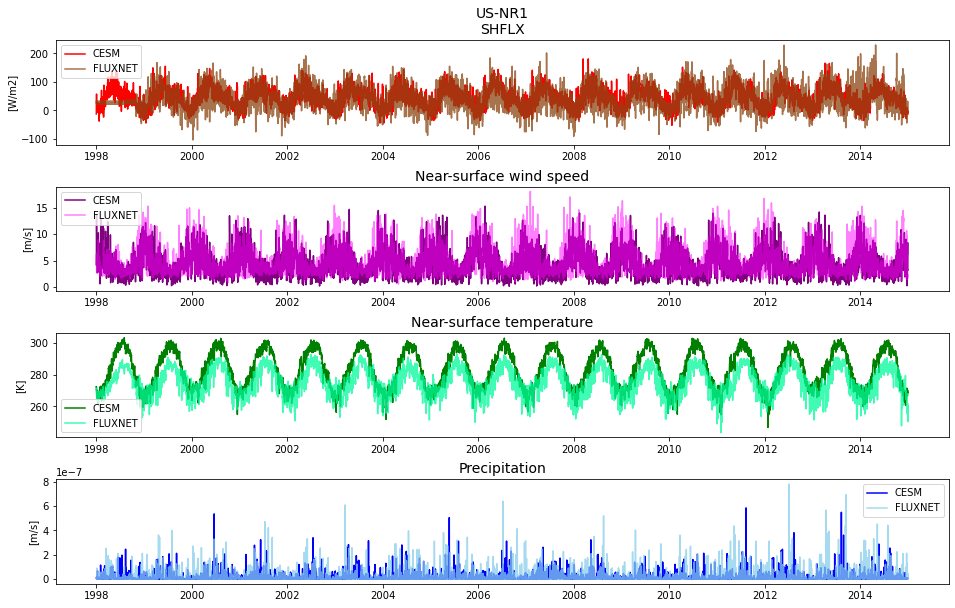

In [83]:
fig, axs = plt.subplots(4,1, figsize=(16, 10))
#Put axs handles in array, axs 
axs = axs.ravel()
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.4,wspace = 0.25)


# ------------------------------------
#   Panel 1: SHFLX 
axs[0].plot(modelDS_station.time.values, modelDS_station.model_SH.values,'r-')
axs[0].plot(dayRange, fluxnet_SH[stationChoice,:],'saddlebrown',alpha=0.75)
axs[0].legend(['CESM','FLUXNET'])
axs[0].set_title(stationID[stationChoice]+'\nSHFLX', fontsize=14)
axs[0].set_ylabel('[W/m2]')

# ------------------------------------
#  Panel 2: Wind speed 
axs[1].plot(modelDS_station.time.values, modelDS_station.model_spd.values,'purple')
axs[1].plot(dayRange, fluxnet_spd[stationChoice,:],'magenta',alpha=0.5)
axs[1].legend(['CESM','FLUXNET'])
axs[1].set_title('Near-surface wind speed', fontsize=14)
axs[1].set_ylabel('[m/s]')

# ------------------------------------
#  Panel 3: Surface temperature 
axs[2].plot(modelDS_station.time.values, modelDS_station.model_TS.values,'green')
axs[2].plot(dayRange, fluxnet_temp_K[stationChoice,:],'mediumspringgreen',alpha=0.75)
axs[2].legend(['CESM','FLUXNET'])
axs[2].set_title('Near-surface temperature', fontsize=14)
axs[2].set_ylabel('[K]')

# ------------------------------------
#  Panel 4: Precipitation
axs[3].plot(modelDS_station.time.values, modelDS_station.model_precip.values,'blue')
axs[3].plot(dayRange, fluxnet_precip_ms[stationChoice,:],'skyblue',alpha=0.75)
axs[3].legend(['CESM','FLUXNET'])
axs[3].set_title('Precipitation', fontsize=14)
axs[3].set_ylabel('[m/s]')


plt.show()